In [486]:
%load_ext autoreload
%autoreload 2
import numpy as np

from ase.build import mx2
from ase.io import read

from tensorwaves.waves import ProbeWaves, GaussianWaves, PrismWaves
from tensorwaves.potentials import Potential
from tensorwaves.detect import RingDetector
import matplotlib.pyplot as plt
import tensorflow as tf

from ase import Atoms
from ase.visualize import view

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [487]:
def detect_pristine_graphene(image, min_hole_distance):
    image = -gaussian_filter(image, min_hole_distance)
    peaks = peak_local_max(image, min_distance=min_hole_distance, indices=False)
    labels, n = scipy.ndimage.label(peaks)

    points = np.array(scipy.ndimage.center_of_mass(peaks, labels, range(1, n+1)))
    delaunay = scipy.spatial.Delaunay(points)
    simplices = delaunay.simplices
    
    neighbors = delaunay.neighbors
    peaks = peak_local_max(image, min_distance=min_hole_distance, indices=True)

    return np.mean(points[simplices], axis=1)

In [490]:
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
import scipy
from sklearn.neighbors import NearestNeighbors

image = np.load('test.npy')

all_points = detect_pristine_graphene(image, 20)

border = 100
scan_margin = 8
valid_points = all_points.copy()




nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(all_points)
distances, indices = nbrs.kneighbors(valid_points)

positions = np.hstack((valid_points,np.full((len(valid_points),1),.75)))

scale = 1.42 / np.mean(distances[:,1:])

cell = np.array([image.shape[0]*scale, image.shape[1]*scale, 1.5])

atoms = Atoms('C'*len(valid_points), 
              positions=positions*scale,
             cell=cell)

potential = Potential(atoms, sampling=.2, num_slices=1, method='fourier')

#plt.figure(figsize=(8,8))
#plt.plot(*atoms.get_positions()[:,:2].T,'ro')
#plt.imshow(image.T, extent=[0, image.shape[0]*scale, 0, image.shape[1]*scale], origin='lower', cmap='gray')

scan_start = np.array([border*scale, border*scale]) + scan_margin
scan_end = np.array([(image.shape[0] - border)*scale, (image.shape[0] - border)*scale]) - scan_margin

scan_start_pixels = np.round(image.shape[0] * scan_start / cell[0]).astype(int)
scan_end_pixels = np.round(image.shape[1] * scan_end / cell[1]).astype(int)


scanned_image = image[scan_start_pixels[0] : scan_end_pixels[0],
                      scan_start_pixels[1] : scan_end_pixels[1]]

#plt.plot(*scan_start.T,'x')
#plt.plot(*scan_end.T,'x')

#plt.figure()
#plt.imshow(scanned_image)

#for i,position in enumerate(atoms.get_positions()[:,:2]):
#    plt.annotate('{}'.format(i),xy=position)

In [4]:
#atoms = read('../data/graphene.traj')
#atoms *= (3,2,1)
#cell = np.diag(atoms.get_cell())
#print('Simulation super cell:', cell)

In [492]:
prism = PrismWaves(cutoff=.03, sampling=.2, interpolation=3, energy=80e3)
S = prism.multislice(potential)

Multislice [||||||||||||||||||||||||||||||||||||||||||||||||||] 1/1 


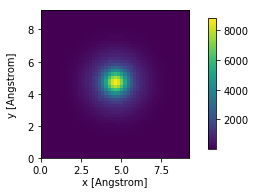

In [622]:
S.get_probe().show()

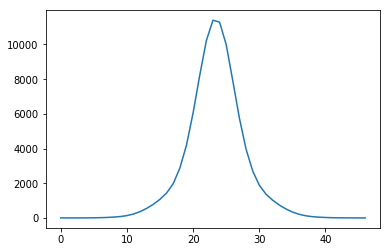

In [631]:
S.gaussian_aperture.amplitude = [1, 10]
S.gaussian_aperture.radius = [.025, .009]

image = S.get_probe().image().numpy()

plt.plot(image[0,image.shape[1]//2])
#plt.scatter(S.kx,S.ky,c=np.log(S.get_coefficients()),s=200)
#plt.colorbar()
#plt.scatter(S.kx, S.ky, c=np.log(S.gaussian_aperture.get_tensor()),s=300)
#plt.colorbar()

In [632]:
detector = RingDetector(inner=.05, outer=.2)

scan = S.gridscan(start=scan_start,
                      end=scan_end, 
                      sampling=.05,                      
                      detectors=detector)

Scanning [||||||||||||||||||||||||||||||||||||||||||||||||||] 15625/15625 


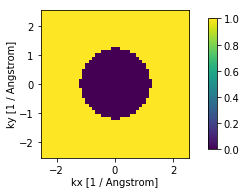

In [633]:
detector.get_tensor().show(display_space='fourier')

In [702]:
max_position = atoms.get_positions()[53,:2][None]

max_scan = S.custom_scan(positions=max_position, detectors=detector)

max_scan.numpy()#/image.max()

array([0.0004347], dtype=float32)

In [703]:
min_position = np.mean(atoms.get_positions()[52:58,:2],axis=0)

min_scan=S.custom_scan(positions=min_position[None], detectors=detector)
print(min_scan.numpy())


(0.0001048 + 0.00012198) / 2

[0.0002394]


0.00011339

In [666]:
0.0004347/0.0002394

1.8157894736842106

0.00043175034940961236 0.0002408595901480457


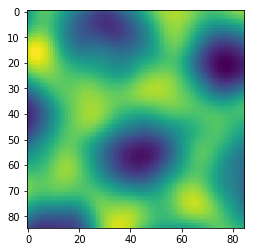

In [744]:
from scipy.ndimage import gaussian_filter

filtered = gaussian_filter(image+ .0002*np.random.randn(*image.shape),5)

plt.imshow(filtered[20:-20,20:-20])


print(np.max(filtered), np.min(filtered))

0.00044272086


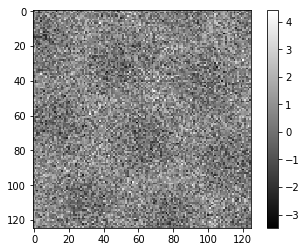

In [711]:
from tensorwaves.learn.invert import DataGenerator

image = scan.image().numpy()[0] #,(232,232))
print(image.max())
#image = scan.image().numpy()[0]

start = scan._start
end = scan._end
num_positions = image.shape

x = np.linspace(start[0], end[0], num_positions[0])
y = np.linspace(start[1], end[1], num_positions[1])
y, x = np.meshgrid(y, x)
positions = np.stack((np.reshape(x, (-1,)), np.reshape(y, (-1,))), axis=1)

values = image.ravel() + .0002*np.random.randn(image.ravel().shape[0])

#min_value = 
#max_value = 0.00044130042

min_value = 0.00024023296
max_value = 0.00044130042

#min_value = 0.00024023296
#max_value = 0.00044130042

values = (values - min_value) / (max_value - min_value)


#values = (values - min_scan.numpy()) / (max_scan.numpy() - min_scan.numpy()) #/ image.max()
#values = np.random.poisson((image.ravel())*a)/a

gen = DataGenerator(positions, values, 128)

image.max()

plt.imshow(np.array(values).reshape(image.shape),cmap='gray')
plt.colorbar()

#print(1/scan2.numpy())

In [712]:
from tensorwaves.prism import PrismTranslate
from tensorwaves.utils import complex_exponential
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam, SGD
import time

def gaussian(r2, a, b):
    return a * tf.exp(-r2 / (.5 * b ** 2))


def gaussian_derivative(r, r2, a, b):
    return - 2 * a * 1 / b ** 2 * r * tf.exp(-r2 / b ** 2)


def soft_gaussian(r, r2, a, b, r_cut):
    return (gaussian(r2, a, b) - gaussian(r_cut ** 2, a, b) - (r - r_cut) * 
            gaussian_derivative(r_cut, r_cut ** 2, a, b))


def wrapped_slice(tensor, begin, size):
    shift = [-x for x in begin]
    tensor = tf.roll(tensor, shift, list(range(len(begin))))
    return tf.slice(tensor, [0] * len(begin), size)


#def gradient_clipping(gradient, max_update, ):
    

class ProbeModel(object):

    def __init__(self, S, detector, bounds):
        self._S = S
        detector.extent = S.probe_extent
        detector.gpts = S.probe_gpts
        detector.energy = S.energy
        self._detector = detector.get_tensor().tensorflow()[0]

        self._translate = PrismTranslate(kx=S.kx, ky=S.ky)
        self._bounds = bounds
        #self._amplitude = tf.Variable(tf.constant([1. ,#* 2 * np.pi * .0075**2, 
        #                                           8. #* 2 * np.pi * .02**2
        #                                          ],dtype=tf.float32))
        #self._radius = tf.Variable(tf.constant([.021, .006], dtype=tf.float32))
        
        alpha_x = self._S.kx * self._S.wavelength
        alpha_y = self._S.ky * self._S.wavelength
        self._alpha2 = alpha_x ** 2 + alpha_y ** 2

        self._amplitude = tf.Variable(tf.random.uniform((10,),dtype=tf.float32))
        #print(self._amplitude)
        self._radius = tf.Variable(tf.constant(tf.linspace(bounds[0],bounds[1],10), dtype=tf.float32))

    def get_coefficients(self):
        amplitude = tf.abs(self._amplitude)
        radius = tf.abs(self._radius)
        return tf.reduce_sum(tf.cast(gaussian(self._alpha2[:,None], amplitude[None,:],# * normalization, 
                                              radius[None,:]),tf.complex64),axis=1)

    def get_probe(self, position):
        self._translate.position = position
        coefficients = self._translate.get_tensor() * self.get_coefficients()
        return tf.abs(tf.reduce_sum(self._S._tensorflow * coefficients[:, None, None], axis=0)) ** 2

    def predict(self, x, coefficients):
        

        self._translate.position = x
        
        begin = [
         np.round((self._translate.position[0] - self._S.extent[0] / (2 * self._S.interpolation)) /
                  self._S.sampling[0]).astype(int),
         np.round((self._translate.position[1] - self._S.extent[1] / (2 * self._S.interpolation)) /
                  self._S.sampling[1]).astype(int)]

        size = [np.ceil(self._S.gpts[0] / self._S.interpolation).astype(int),
                np.ceil(self._S.gpts[1] / self._S.interpolation).astype(int)]
        
        #start = time.time()
        coefficients = self._translate.get_tensor() * coefficients
        #end = time.time()
        #print(end - start)
        
        #start = time.time()
        #tensor = wrapped_slice(self._S.tensorflow(), begin, size)
        tensor = self._S.tensorflow()[:,
                                      begin[0]:begin[0]+size[0],
                                      begin[1]:begin[1]+size[1]]
        #end = time.time()
        #print(end - start)
        #start = time.time()
        
        probe = tf.reduce_sum(tensor * coefficients[:, None, None], axis=0)
        end = time.time()
        #print(end - start)
        
        #start = time.time()
        diffraction = tf.abs(tf.signal.fft2d(probe)) ** 2
        
        y_predict = tf.reduce_sum(tf.boolean_mask(diffraction, self._detector))
        
        #print(tf.reduce_sum(diffraction))
        #end = time.time()
        #print(end - start)
        #ssss
        #print(y_predict)
        #sss
        return y_predict / tf.reduce_sum(diffraction)

    def fit_generator(self, data_generator, num_epochs, optimizers, calibration, callback=None):
        
        steps_per_epoch = len(data_generator)
        
        loss = []
        values = np.zeros(len(data_generator))
        best_guess_loss = []
        d=[]
        i = 0
        
        max_value = 0.00018204
        min_value = 0.00010046
        
        for epoch in range(num_epochs):
            epoch_loss = 0.
            
            for j in range(steps_per_epoch):
                indices, X_batch, Y_batch = next(data_generator)

                batch_predict = tf.zeros([len(X_batch), 1])
                batch_y = tf.zeros([len(Y_batch), 1])

                with tf.GradientTape() as tape:
                    batch_loss = 0.
                    #max_value = (.1 * self.predict(calibration[1]) + .9 * max_value)# / 2.
                            
                    #start = time.time()
                    coefficients = self.get_coefficients()
                    #end = time.time()
                    #print(end - start)
                    max_value = self.predict(calibration[1], coefficients)
                    min_value = self.predict(calibration[0], coefficients)
                    
                    #max_value = (0.5 * max_value_ + .5 * max_value)
                    #min_value = (0.5 * min_value_ + .5 * min_value)
                    
                    for j, (x, y) in enumerate(zip(X_batch, Y_batch)):
                        y_predict = (self.predict(x, coefficients) - min_value) / (max_value - min_value)
                        
                        batch_loss += tf.reduce_sum(tf.square(y - y_predict))
                        #batch_loss += tf.reduce_sum(1e-1 * tf.maximum(self._bounds[0] - tf.abs(self._radius), 0.))
                        #batch_loss += tf.reduce_sum(1e-1 * tf.maximum(tf.abs(self._radius) - self._bounds[1], 0.))
                        #print(batch_loss)
                        
                        #sss
                        values[indices[j]] = y_predict
                    
                    batch_loss /= len(X_batch)
                    
                    batch_loss += .1 * (max_value/min_value - 1.8157894736842106)**2
                
                loss.append(batch_loss)

                grads = tape.gradient(batch_loss, [self._amplitude, self._radius])

                optimizers[0].apply_gradients(zip([grads[0]], [self._amplitude]))
                optimizers[1].apply_gradients(zip([grads[1]], [self._radius]))

                i += 1
                print(max_value, max_value/min_value)
                print(self._radius)
                print(self._amplitude)

                fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(14,6))
                ax1.plot(loss)
                ax2.imshow(np.array(values).reshape(image.shape).T,vmin=0,vmax=data_generator.values.max())
                ax3.imshow(np.array(data_generator.values).reshape(image.shape).T,vmin=0)

                d += [np.sum(tf.abs((S.gaussian_aperture.get_tensor()/np.max(S.gaussian_aperture.get_tensor()) - 
                     tf.cast(self.get_coefficients() / np.max(self.get_coefficients()),dtype=tf.float32))) ** 2)]

                ax4.plot(d)
                ax5.plot(S.gaussian_aperture.get_tensor() / np.max(S.gaussian_aperture.get_tensor()))
                ax5.plot(self.get_coefficients() / np.max(self.get_coefficients()), '.')
                
                plt.show()
                #sss
                clear_output(wait=True)

from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta

model = ProbeModel(S, RingDetector(inner=.05, outer=.2), bounds=[.005,.025])

In [745]:
#optimizers = [SGD(1e8),SGD(1e3)]
optimizers = [SGD(4e7 / 8000**2, momentum=.0),
              SGD(4e3 / 8000**2, momentum=.0)]

max_value = image.max()
max_position = atoms.get_positions()[53,:2]

calibration = (min_position, max_position)

model.fit_generator(gen, 30, optimizers, calibration=calibration)

KeyboardInterrupt: 

In [75]:
#optimizers = [SGD(1e8),SGD(1e3)]
optimizers = [SGD(1e1, momentum=.2), SGD(1e-3, momentum=.2), SGD(1.e3, momentum=.2)]
model.fit_generator(gen, 30, optimizers, optimize_scale_only=False)

KeyboardInterrupt: 

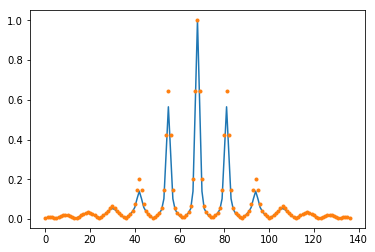

In [464]:
plt.plot(S.gaussian_aperture.get_tensor()/np.max(S.gaussian_aperture.get_tensor()))
plt.plot(model.get_coefficients() / np.max(model.get_coefficients()),'.')
#plt.plot(tf.cast(model.get_coefficients() / np.max(model.get_coefficients()),tf.float32)-
#         tf.cast(S.gaussian_aperture.get_tensor()/np.max(S.gaussian_aperture.get_tensor()),tf.float32))

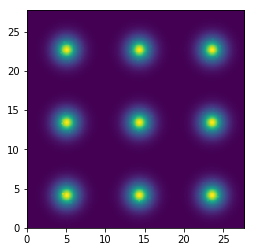

In [186]:
plt.imshow(model.get_probe((5,5)).numpy().T, extent=[0,S.extent[0],0,S.extent[1]])
plt.show()

In [334]:
#model.get_probe()
v = []
for position in positions:
    v.append(model.predict(position))
##.show()

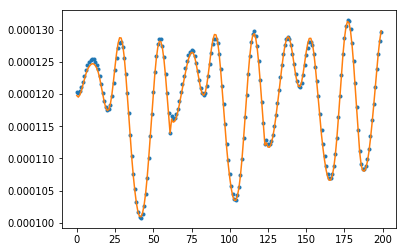

In [341]:
plt.plot(np.array(v)[:200],'.')
plt.plot(values[:200])

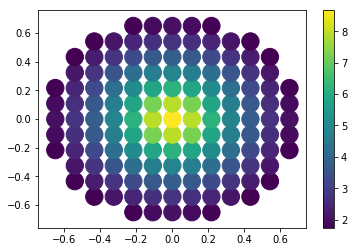

In [101]:
plt.scatter(S.kx, S.ky, c=np.log(tf.abs(model.get_coefficients())), s=300)
plt.colorbar()